In [ ]:
import torch
import torch.nn as nn

import torchvision.utils
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from algo.variable_optim import VSGD

import torchattacks
from torchattacks import PGD, FGSM

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from py.nets import TransferAttackCNN, Conv1
from py.attacks import get_attacks
from torch import optim
import torch.nn as nn

from py.train import train_mnist, test
from py.utils import get_default_device

import matplotlib.pyplot as plt
import pandas as pd

#use_pretrained_models = True

# Load Data

In [2]:
device = get_default_device()

transform = transforms.Compose([transforms.ToTensor(),
            ])

n_epochs = 5
batch_size = 128
learning_rate = 0.01
momentum = 0.9

test_set = datasets.MNIST('./datasets', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)

train_set = datasets.MNIST('./datasets', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Show example images

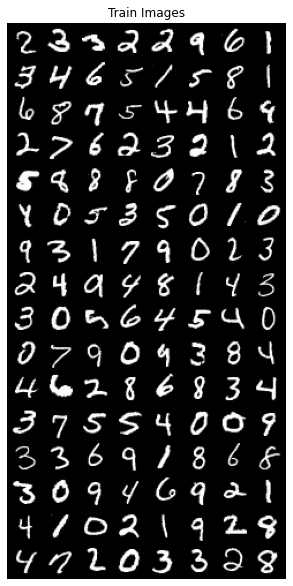

In [3]:
from py.utils import imshow
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Images")

# Set up attack model

In [4]:
attack_model = TransferAttackCNN()
# using stochastic gradient descent
sgd_optim = optim.SGD(attack_model.parameters(), lr=learning_rate, momentum=momentum)
# specify loss function
criterion = nn.CrossEntropyLoss()

# Train attack model

In [5]:
train_losses, train_counter = train_mnist(attack_model, sgd_optim, criterion, test_loader, device, n_epochs=12)
test(attack_model, test_loader, device, classes)

  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

98.45

# Generate Adversarial Images

In [6]:
atks = get_attacks(attack_model)
for atk in atks:
    atk_name = atk.__class__.__name__
    print(f"Running {atk_name}")
    atk.set_return_type('int') # Save as integer.
    atk.save(data_loader=test_loader, save_path=f"./results/mnist_{atk_name}.pt", verbose=True)

Running FGSM
- Save progress: 100.00 % / Robust accuracy: 12.26 % / L2: 6.36028 (0.012 it/s) 	
Running PGD
- Save progress: 100.00 % / Robust accuracy: 0.49 % / L2: 5.82259 (0.012 it/s) 	
Running CW
- Save progress: 100.00 % / Robust accuracy: 98.45 % / L2: 0.00000 (0.288 it/s) 	


# Set up and train base model

In [7]:
base_model = Conv1()
base_model.to(device)
sgd_optim = optim.SGD(base_model.parameters(), lr=learning_rate, momentum=momentum)
train_losses, train_counter = train_mnist(base_model, sgd_optim, criterion, test_loader, device, n_epochs=6)

  0%|          | 0/474 [00:00<?, ?it/s]

# Test base model on adversarial images

In [8]:
sgd_robust_accs = {}

clean_acc = test(base_model, test_loader, device, classes)
sgd_robust_accs['clean'] = clean_acc

for atk in atks:
    atk_name = atk.__class__.__name__
    print(f"Test base model on adv images generated by {atk_name}")
    adv_images, adv_labels = torch.load(f"./results/mnist_{atk_name}.pt")
    adv_data = torch.utils.data.TensorDataset(adv_images.float()/255, adv_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    robust_acc = test(base_model, adv_loader, device, classes)
    sgd_robust_accs[atk_name] = robust_acc
    print(f'Robust acc for {atk_name}: {robust_acc:.2f}')
    
d = {}
d['sgd'] = sgd_robust_accs

  0%|          | 0/79 [00:00<?, ?it/s]

Test base model on adv images generated by FGSM


  0%|          | 0/79 [00:00<?, ?it/s]

Robust acc for FGSM: 29.12


Test base model on adv images generated by PGD


  0%|          | 0/79 [00:00<?, ?it/s]

Robust acc for PGD: 17.31


Test base model on adv images generated by CW


  0%|          | 0/79 [00:00<?, ?it/s]

Robust acc for CW: 98.27




# Set up variabilities to test

In [12]:
variabilities = [0.1, 0.0015, 0.002, 0.005, 0.01]

# Test target model on adversarial images

In [13]:
for var in variabilities:
    var_robust_accs = {}
    v_model = Conv1()
    v_model.to(device)

    criterion = nn.CrossEntropyLoss()

    vsgd_optim = VSGD(v_model.parameters(), variability=var, lr=learning_rate, momentum=momentum)
    train_losses, train_counter = train_mnist(v_model, vsgd_optim, criterion, test_loader, device, n_epochs=6)
    
    clean_acc = test(v_model, test_loader, device, classes)
    var_robust_accs['clean'] = clean_acc
    print(f"Results for testing with variability {var}:")
    for atk in atks:
        atk_name = atk.__class__.__name__
        adv_images, adv_labels = torch.load(f"./results/mnist_{atk_name}.pt")
        adv_data = torch.utils.data.TensorDataset(adv_images.float()/255, adv_labels)
        adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
        robust_acc = test(v_model, adv_loader, device, classes)
        var_robust_accs[atk_name] = robust_acc
        print(f'\tRobust acc for {atk_name}: {robust_acc:.2f}')
    print("-"*80)
    d["VSGD_" + str(var)] = var_robust_accs

  0%|          | 0/474 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Results for testing with variability 0.1:


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for FGSM: 12.38
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for PGD: 12.44
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for CW: 17.68
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


  0%|          | 0/474 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Results for testing with variability 0.0015:


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for FGSM: 30.09
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for PGD: 17.03
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for CW: 98.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


  0%|          | 0/474 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Results for testing with variability 0.002:


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for FGSM: 26.85
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for PGD: 13.39
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for CW: 98.43
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


  0%|          | 0/474 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Results for testing with variability 0.005:


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for FGSM: 29.44
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for PGD: 17.41
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for CW: 97.24
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


  0%|          | 0/474 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Results for testing with variability 0.01:


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for FGSM: 30.93
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for PGD: 21.44
--------------------------------------------------------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

	Robust acc for CW: 96.28
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


# Plot Comparison Bar Chart

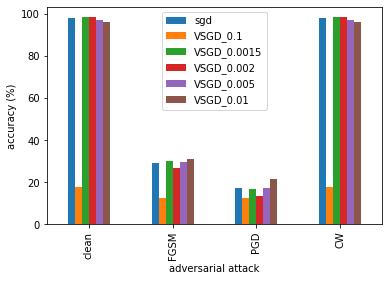

Accuracies: 
{'VSGD_0.0015': {'CW': 98.45, 'FGSM': 30.09, 'PGD': 17.03, 'clean': 98.45},
 'VSGD_0.002': {'CW': 98.43, 'FGSM': 26.85, 'PGD': 13.39, 'clean': 98.43},
 'VSGD_0.005': {'CW': 97.24, 'FGSM': 29.44, 'PGD': 17.41, 'clean': 97.24},
 'VSGD_0.01': {'CW': 96.28, 'FGSM': 30.93, 'PGD': 21.44, 'clean': 96.28},
 'VSGD_0.1': {'CW': 17.68, 'FGSM': 12.38, 'PGD': 12.44, 'clean': 17.68},
 'sgd': {'CW': 98.27, 'FGSM': 29.12, 'PGD': 17.31, 'clean': 98.27}}


In [15]:
pd.DataFrame(d).plot(kind='bar')
plt.ylabel('accuracy (%)')
plt.xlabel('adversarial attack')
plt.savefig('./plots/mnist_transfer_attack.png', dpi=300, bbox_inches='tight')
plt.show()

import pprint
print("Accuracies: ")
pprint.pprint(d)